#  **Data Analysis and Visualization on DonorChoose**


DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:

How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible

How to increase the consistency of project vetting across different volunteers to improve the experience for teachers

How to focus volunteer time on the applications that need the most assistance

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

**About the DonorsChoose Data Set**

The train.csv data set provided by DonorsChoose contains the following features:

Description of Columns:

project_id	  A unique identifier for the proposed project.

project_title    Title of the project.

project_grade_category	Grade level of students for which the project is targeted.

project_subject_categories	One or more (comma-separated) subject categories for the project

school_state	State where school is located (Two-letter U.S. postal code)

project_subject_subcategories	One or more (comma-separated) subject subcategories for the project

project_resource_summary	An explanation of the resources needed for the project. 

project_essay_1	First application essay*

project_essay_2	Second application essay*

project_essay_3	Third application essay*

project_essay_4	Fourth application essay*

project_submitted_datetime	Datetime when project application was submitted. 

teacher_id	A unique identifier for the teacher of the proposed project.

teacher_prefix	Teacher's title. One of the following enumerated values:

teacher_number_of_previously_posted_projects	Number of project applications previously submitted by the same teacher


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [5]:
train_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [6]:
train_data

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0
3,45,p246581,f3cb9bffbba169bef1a77b243e620b60,Mrs.,KY,2016-10-06 21:16:17,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Techie Kindergarteners,I work at a unique school filled with both ESL...,My students live in high poverty conditions wi...,NaN,NaN,My students need to engage in Reading and Math...,4,1
4,172407,p104768,be1f7507a41f8479dc06f047086a39ec,Mrs.,TX,2016-07-11 01:10:09,Grades PreK-2,Math & Science,Mathematics,Interactive Math Tools,Our second grade classroom next year will be m...,"For many students, math is a subject that does...",NaN,NaN,My students need hands on practice in mathemat...,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109243,38267,p048540,fadf72d6cd83ce6074f9be78a6fcd374,Mr.,MO,2016-06-17 12:02:31,Grades PreK-2,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Privacy Shields Help Promote Independent Thinking,Welcome to Mr. Ramos's 2nd grade classroom! We...,I would like to start preparing my second grad...,NaN,NaN,My students need these privacy partitions to h...,0,1
109244,169142,p166281,1984d915cc8b91aa16b4d1e6e39296c6,Ms.,NJ,2017-01-11 12:49:39,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",Technology in Our Classroom,"Every morning, we start our day with our core ...","In this technological age, we need to give our...",NaN,NaN,My students need two iPad's and protective cas...,0,1
109245,143653,p155633,cdbfd04aa041dc6739e9e576b1fb1478,Mrs.,NJ,2016-08-25 17:11:32,Grades PreK-2,"Literacy & Language, Math & Science","Literacy, Mathematics",2016/2017 Beginning of the Year Basics,This is a great group of sharing and caring st...,"My students learn about special events, holida...",NaN,NaN,My students need giant comfy pillows in order ...,3,1
109246,164599,p206114,6d5675dbfafa1371f0e2f6f1b716fe2d,Mrs.,NY,2016-07-29 17:53:15,Grades 3-5,"Health & Sports, Special Needs","Health & Wellness, Special Needs",Flexible Seating in Inclusive Classroom,Our students live in a small rural community. ...,Flexible classroom seating has been researched...,NaN,NaN,My students need flexible seating options: bea...,0,1


In [7]:
train_data['project_is_approved'].value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

In [9]:
def stack_plot(data,xtick,col2='project_is_approved',col3='total'):
    index=np.arange(data.shape[0])
    p1=plt.bar(index,data[col3].values)
    p2=plt.bar(index,data[col2].values)
    plt.ylabel('Projects')
    plt.title('Project approved applicant wise')
    plt.xticks(index,list(data[xtick].values))
    plt.legend((p1[0],p2[0]),('total','accepted'))
    plt.gca().yaxis.grid(linestyle=':')
    plt.show()

In [10]:
def barplots(data,col1,col2='project_is_approved',top=False):
    temp=pd.DataFrame(train_data.groupby(col1)[col2].agg(lambda x:x.eq(1).sum())).reset_index()
    temp['total']=pd.DataFrame(train_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['avg']=pd.DataFrame(train_data.groupby(col1)[col2].agg({'avg':'mean'})).reset_index()['avg']
    temp.sort_values(by=['total'],inplace=True,ascending=False)
    if top:
        temp=temp[0:50]
    stack_plot(temp,xtick=col1,col2=col2,col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))


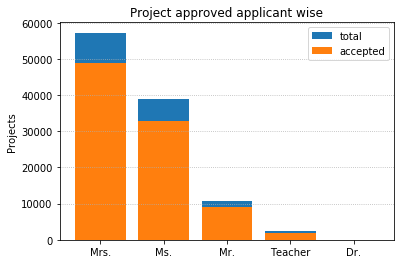

  teacher_prefix  project_is_approved  total       avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [11]:
#teacher_prefix analysis
barplots(train_data,'teacher_prefix','project_is_approved',top=False)

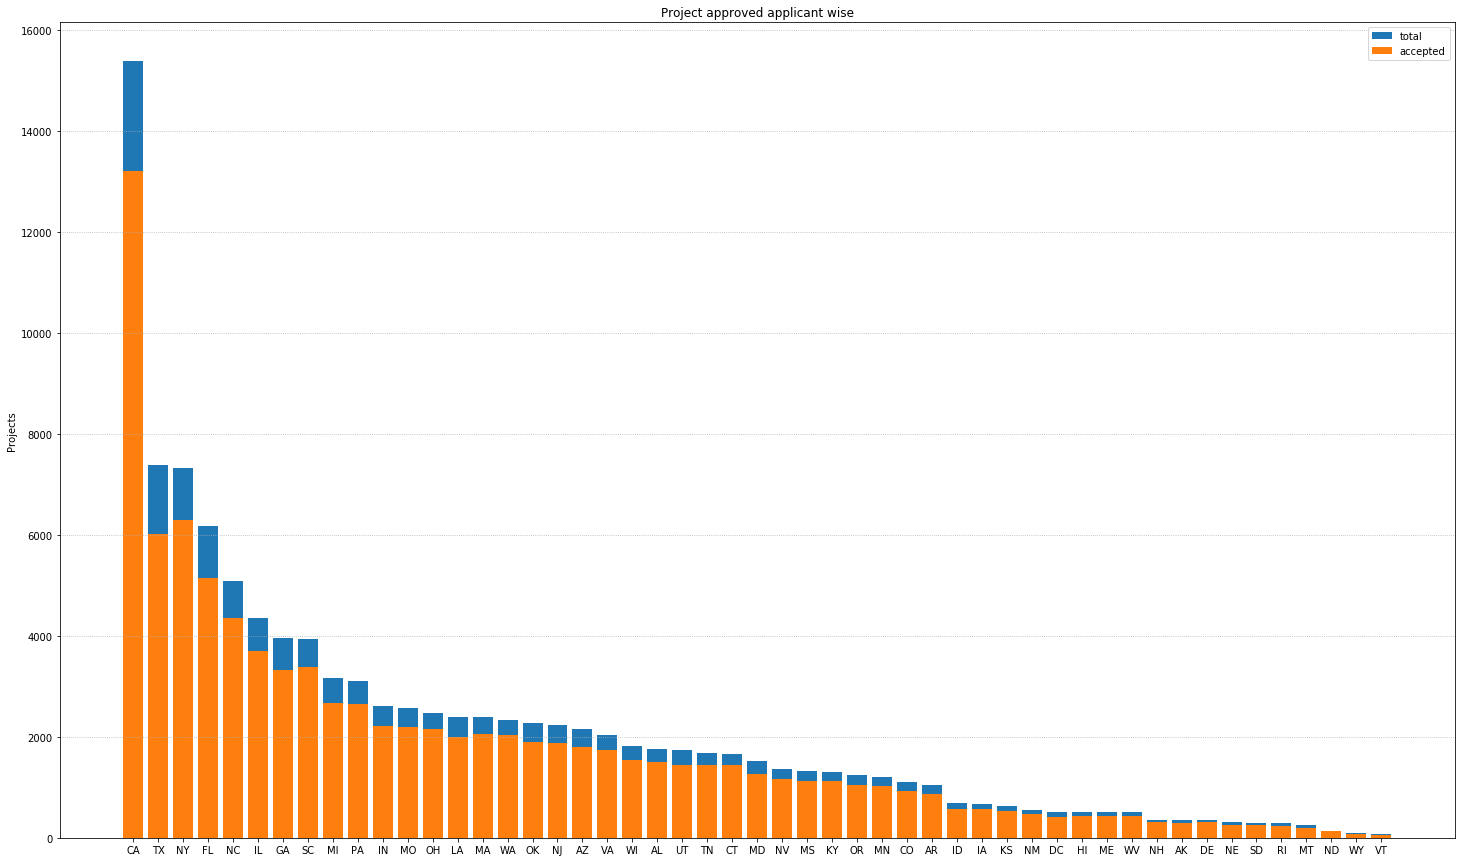

   school_state  project_is_approved  total       avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [13]:
#Student_state analysis
plt.figure(figsize=(25,15))
barplots(train_data,'school_state','project_is_approved',top=False)

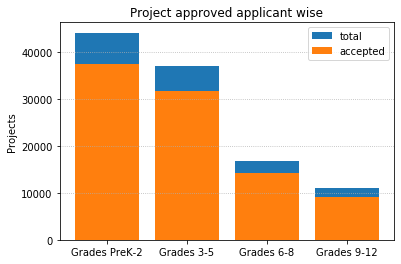

  project_grade_category  project_is_approved  total       avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [14]:
#Project Grade Category
barplots(train_data,'project_grade_category','project_is_approved',top=False)

In [15]:
train_data['project_subject_categories']=train_data['project_subject_categories'].str.replace('&','_')
train_data['project_subject_categories']=train_data['project_subject_categories'].str.replace(' The ','')
train_data['project_subject_categories']=train_data['project_subject_categories'].str.replace(',','_')
train_data['project_subject_categories']=train_data['project_subject_categories'].str.replace(' ','')
train_data['project_subject_categories']=train_data['project_subject_categories'].str.lower()

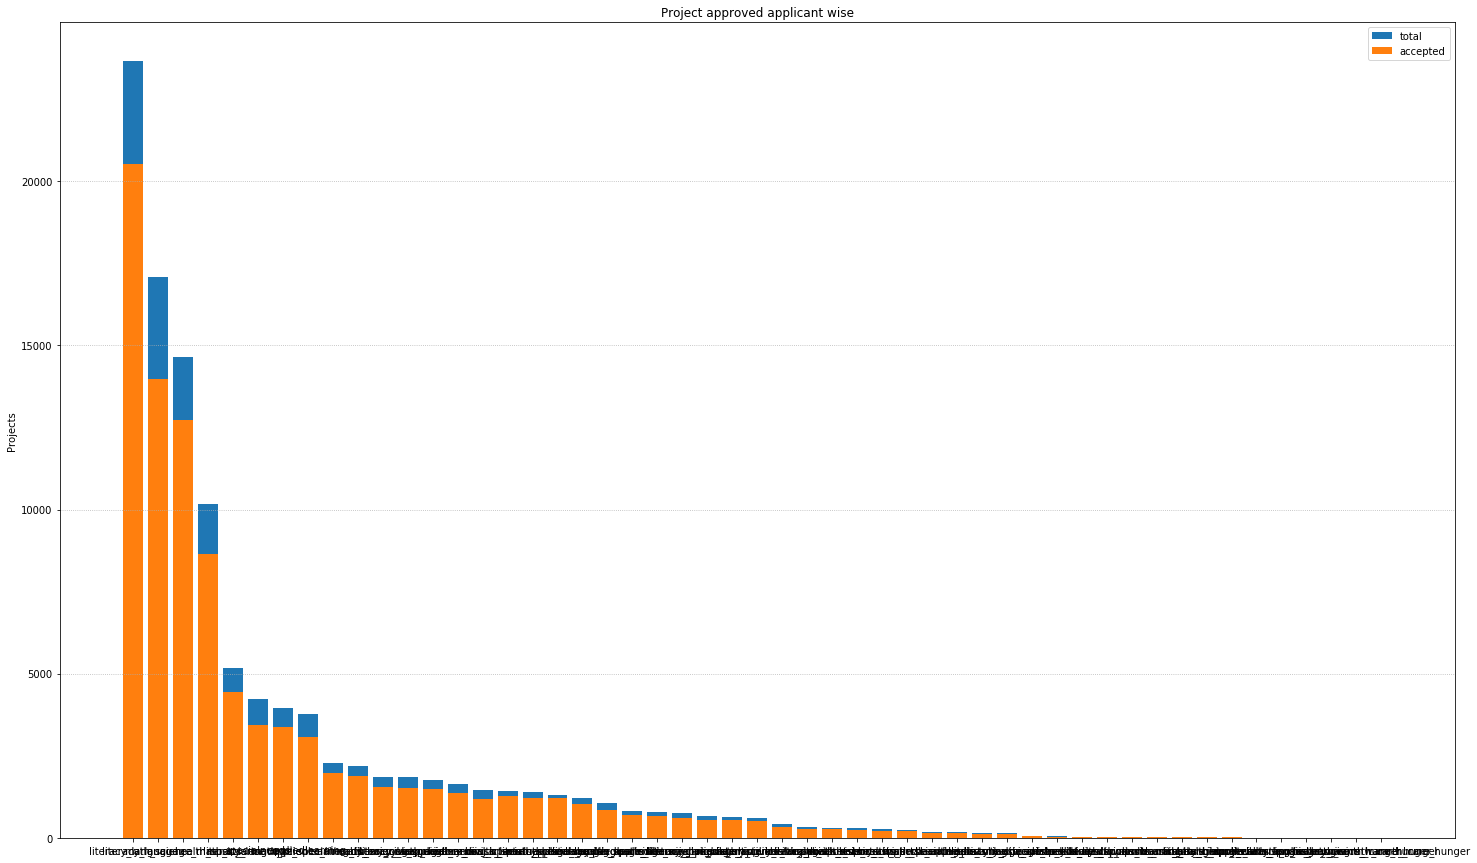

        project_subject_categories  project_is_approved  total       avg
24               literacy_language                20520  23655  0.867470
32                    math_science                13991  17072  0.819529
28  literacy_language_math_science                12725  14636  0.869432
8                    health_sports                 8640  10177  0.848973
40                      music_arts                 4429   5180  0.855019
              project_subject_categories  project_is_approved  total       avg
41            music_arts_appliedlearning                    7     10  0.700000
7     appliedlearning_warmth_care_hunger                    8     10  0.800000
31  literacy_language_warmth_care_hunger                    7      9  0.777778
45         music_arts_warmth_care_hunger                    1      2  0.500000
23     history_civics_warmth_care_hunger                    0      1  0.000000


In [17]:
#project_subject_categories analysis
plt.figure(figsize=(25,15))
barplots(train_data,'project_subject_categories','project_is_approved',top=False)

In [22]:
sub_catogories = list(train_data['project_subject_subcategories'].values)

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [25]:
train_data['project_subject_subcategories'] = sub_cat_list

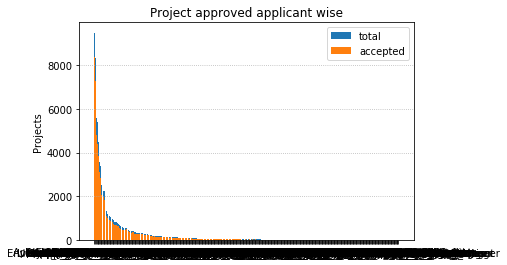

      project_subject_subcategories  project_is_approved  total       avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
            project_subject_subcategories  project_is_approved  total  avg
210     Extracurricular FinancialLiteracy                    1      1  1.0
183          Economics NutritionEducation                    1      1  1.0
316  History_Geography Warmth Care_Hunger                    0      1  0.0
73    Civics_Government ParentInvolvement                    1      1  1.0
375              Other Warmth Care_Hunger                    1      1  1.0


In [26]:
#project_subject_subcategories
barplots(train_data,'project_subject_subcategories','project_is_approved',top=False)

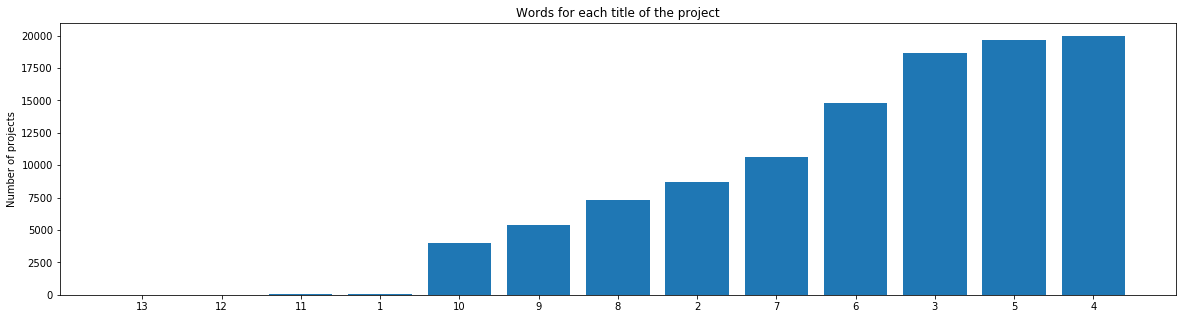

In [27]:
#Project Title Analysis
word_count = train_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of projects')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [31]:
approved_word_count = train_data[train_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = train_data[train_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

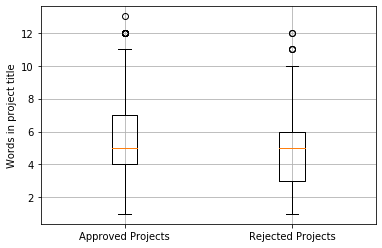

In [32]:
plt.boxplot([approved_word_count, rejected_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

In [34]:
# project_essay analysis
train_data["essay"] =  train_data["project_essay_1"].map(str) +\
                        train_data["project_essay_2"].map(str) + \
                        train_data["project_essay_3"].map(str) + \
                        train_data["project_essay_4"].map(str)

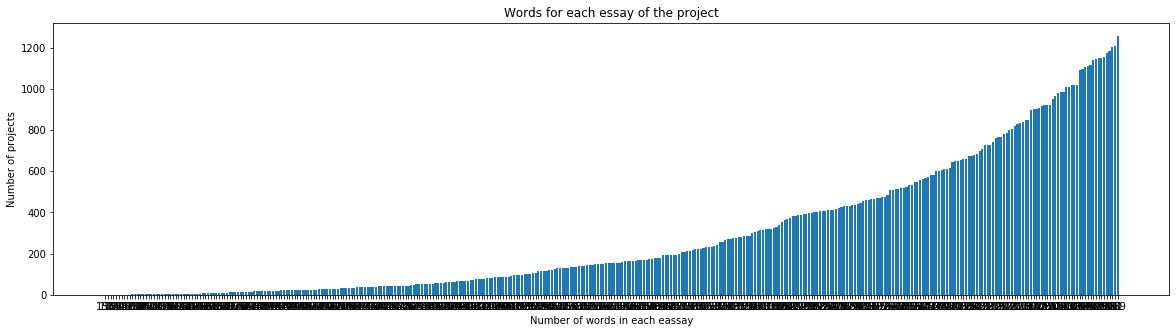

In [36]:
#Calculating no of words in a string
word_count = train_data['essay'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of projects')
plt.xlabel('Number of words in each eassay')
plt.title('Words for each essay of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

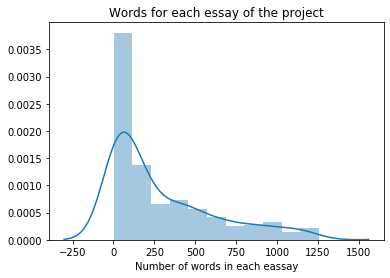

In [37]:
sns.distplot(word_count.values)
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.show()

In [39]:
approved_word_count = train_data[train_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = train_data[train_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

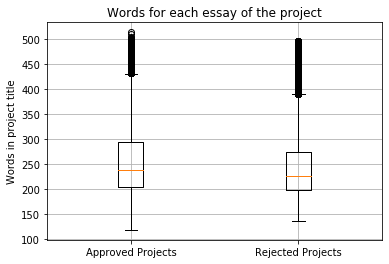

In [40]:
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

In [41]:
#Cost per project Analysis
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()


In [43]:
# join two dataframes in python: 
project_data = pd.merge(train_data, price_data, on='id', how='left')

In [44]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

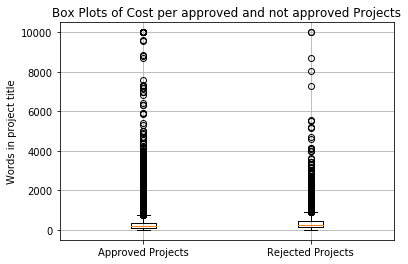

In [45]:
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

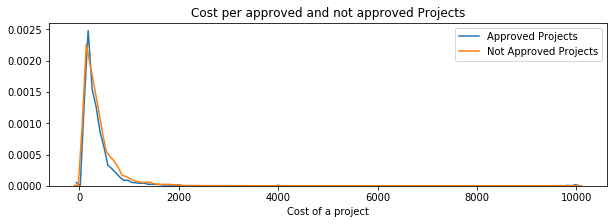

In [46]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

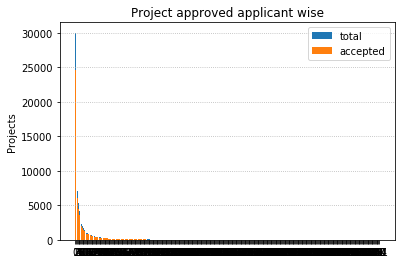

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
     teacher_number_of_previously_posted_projects  project_is_approved  total  \
242                                           242                    1      1   
268                                           270                    1      1   
234                                           234                    1      1   
335                                           347                    1      1   
373                                 

In [48]:
#Teacher_prefix Analysis
barplots(train_data,'teacher_number_of_previously_posted_projects','project_is_approved',top=False)

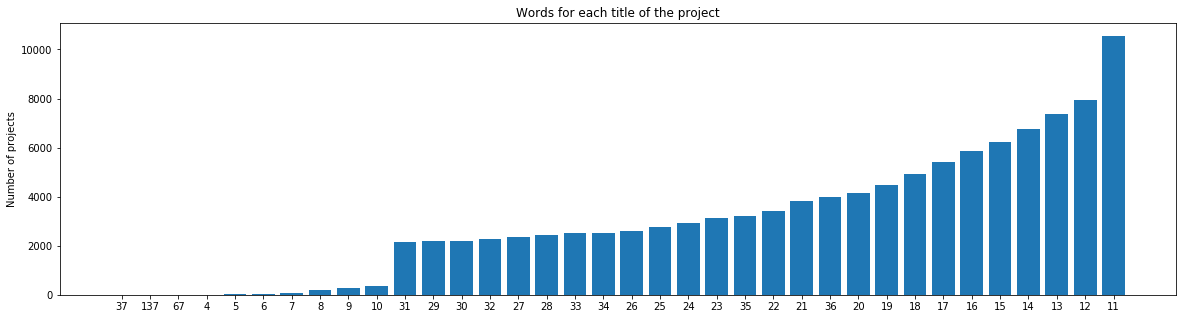

In [54]:
#Project_resource_summary Analysis
word_count = train_data['project_resource_summary'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of projects')
plt.title('Words for each project resource summary')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [55]:
approved_word_count = train_data[train_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = train_data[train_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

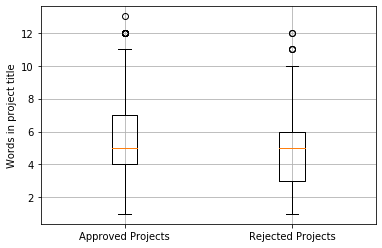

In [57]:
plt.boxplot([approved_word_count, rejected_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()